In [1]:
from keras_tuner import Hyperband
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.mixed_precision import set_global_policy

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650 Ti, compute capability 7.5


In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [4]:
def build_tunable_model(hp):
    model = Sequential()
    
    # Tunable activation function
    activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])
    
    # First Conv2D layer
    model.add(Conv2D(
        filters=hp.Int("filters_1", min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation=activation,
        input_shape=(32, 32, 3)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float("dropout_rate_1", min_value=0.2, max_value=0.5, step=0.1)))

    # Second Conv2D layer
    model.add(Conv2D(
        filters=hp.Int("filters_2", min_value=128, max_value=256, step=32),
        kernel_size=(3, 3),
        activation=activation
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Third Conv2D layer
    model.add(Conv2D(
        filters=hp.Int("filters_3", min_value=128, max_value=256, step=32),
        kernel_size=(3, 3),
        activation=activation
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten for Dense layers
    model.add(Flatten())

    # Dense layer with tunable number of neurons
    model.add(Dense(
        units=hp.Int("dense_units", min_value=256, max_value=1024, step=256),
        activation=activation
    ))
    
    # Output layer
    model.add(Dense(10, activation="softmax", dtype=tf.float32))  # Ensure output is float32 for mixed precision

    # Tunable optimizer and learning rate
    optimizer_name = hp.Choice("optimizer", ["adam", "rmsprop"]) 
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
tuner = Hyperband(
    build_tunable_model,
    objective="val_accuracy",
    max_epochs=10,
    directory="hyperparameter_tuning",
    project_name="activation_and_filters_tuning_2",
)

In [8]:
tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Trial 30 Complete [00h 03m 57s]
val_accuracy: 0.746399998664856

Best val_accuracy So Far: 0.746399998664856
Total elapsed time: 00h 43m 25s


In [9]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best learning rate: {best_hps.get('lr')}")
print(f"Best optimizer: {best_hps.get('optimizer')}")
print(f"Best activation function: {best_hps.get('activation')}")
print(f"Best number of filters in Conv2D layers: {[best_hps.get(f'filters_{i+1}') for i in range(3)]}")
print(f"Best number of units in Dense layer: {best_hps.get('dense_units')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate_1')}")

Best learning rate: 0.0001643184404111684
Best optimizer: rmsprop
Best activation function: relu
Best number of filters in Conv2D layers: [96, 224, 160]
Best number of units in Dense layer: 1024
Best dropout rate: 0.2


In [10]:
final_model = tuner.hypermodel.build(best_hps)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
history = final_model.fit(
    x_train, y_train,
    epochs=50,
    validation_data=(x_test, y_test),
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
1250/1250 [==============================] - 26s 20ms/step - loss: 1.3540 - accuracy: 0.5223 - val_loss: 1.1887 - val_accuracy: 0.5870
Epoch 2/50
1250/1250 [==============================] - 23s 18ms/step - loss: 0.9680 - accuracy: 0.6623 - val_loss: 1.2559 - val_accuracy: 0.5969
Epoch 3/50
1250/1250 [==============================] - 23s 19ms/step - loss: 0.7745 - accuracy: 0.7303 - val_loss: 0.8560 - val_accuracy: 0.7036
Epoch 4/50
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6350 - accuracy: 0.7785 - val_loss: 0.8091 - val_accuracy: 0.7251
Epoch 5/50
1250/1250 [==============================] - 23s 19ms/step - loss: 0.5203 - accuracy: 0.8184 - val_loss: 0.9305 - val_accuracy: 0.7083
Epoch 6/50
1250/1250 [==============================] - 23s 18ms/step - loss: 0.4245 - accuracy: 0.8526 - val_loss: 0.9779 - val_accuracy: 0.6944
Epoch 7/50
1250/1250 [==============================] - 23s 19ms/step - loss: 0.3429 - accuracy: 0.8805 - val_loss: 0.8921 -

In [11]:
final_loss, final_accuracy = final_model.evaluate(x_test, y_test)
print(f"Final Test Loss: {final_loss}")

313/313 [==============================] - 2s 6ms/step - loss: 1.1098 - accuracy: 0.7527
Final Test Loss: 1.1098062992095947


In [12]:
pred = final_model.predict(x_test)

313/313 [==============================] - 1s 4ms/step


In [13]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

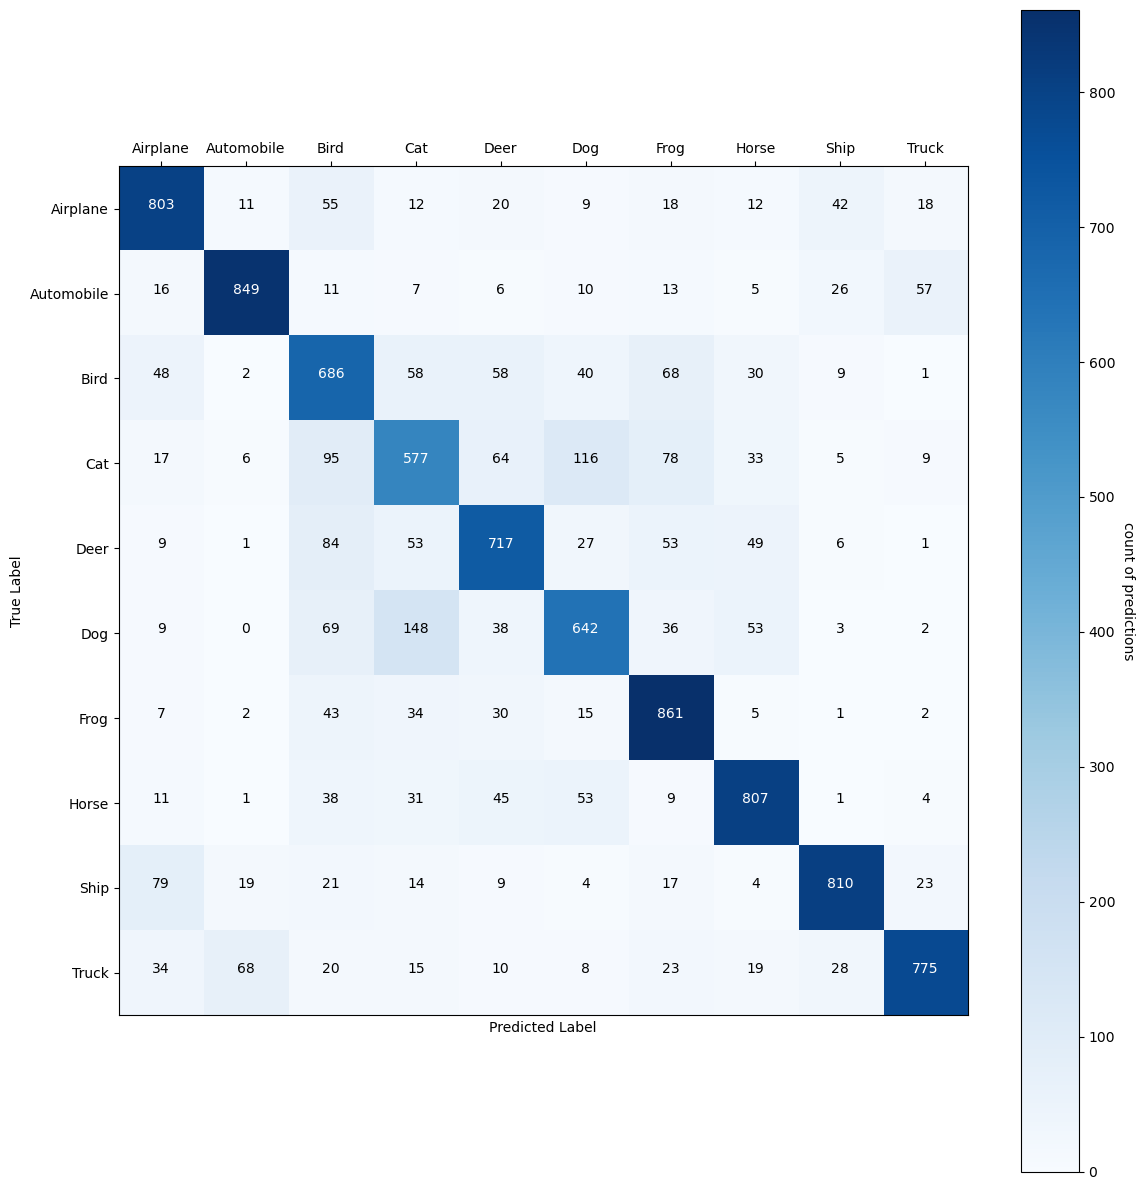

In [16]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [17]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1000
           1       0.89      0.85      0.87      1000
           2       0.61      0.69      0.65      1000
           3       0.61      0.58      0.59      1000
           4       0.72      0.72      0.72      1000
           5       0.69      0.64      0.67      1000
           6       0.73      0.86      0.79      1000
           7       0.79      0.81      0.80      1000
           8       0.87      0.81      0.84      1000
           9       0.87      0.78      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



In [18]:
final_model.save('./cifar10_final')

INFO:tensorflow:Assets written to: ./cifar10_final\assets


INFO:tensorflow:Assets written to: ./cifar10_final\assets
